In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Carregar o dataset pré-dividido: treino, validação e teste
(train_ds, val_ds, test_ds), info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)

# Função para redimensionar e normalizar as imagens
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Tamanho esperado pela VGG16
    image = image / 255.0  # Normalização [0, 1]
    return image, label

# Aplicar o preprocessamento
train_ds = train_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.8T65P5_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
# Resumo do dataset
print("Finished loading dataset: Cats vs Dogs")

# Pega o número de amostras em cada split (train, val, test)
num_train = info.splits['train'].num_examples
num_train_split = int(num_train * 0.8)
num_val_split = int(num_train * 0.1)
num_test_split = num_train - num_train_split - num_val_split

print("Train / Validation / Test split: %d, %d, %d" % (num_train_split, num_val_split, num_test_split))

# Pega uma batch para inspecionar formato das imagens e labels
for images, labels in train_ds.take(1):
    print("Training data shape:", images.shape)
    print("Training labels shape:", labels.shape)


Finished loading dataset: Cats vs Dogs
Train / Validation / Test split: 18609, 2326, 2327
Training data shape: (32, 224, 224, 3)
Training labels shape: (32,)


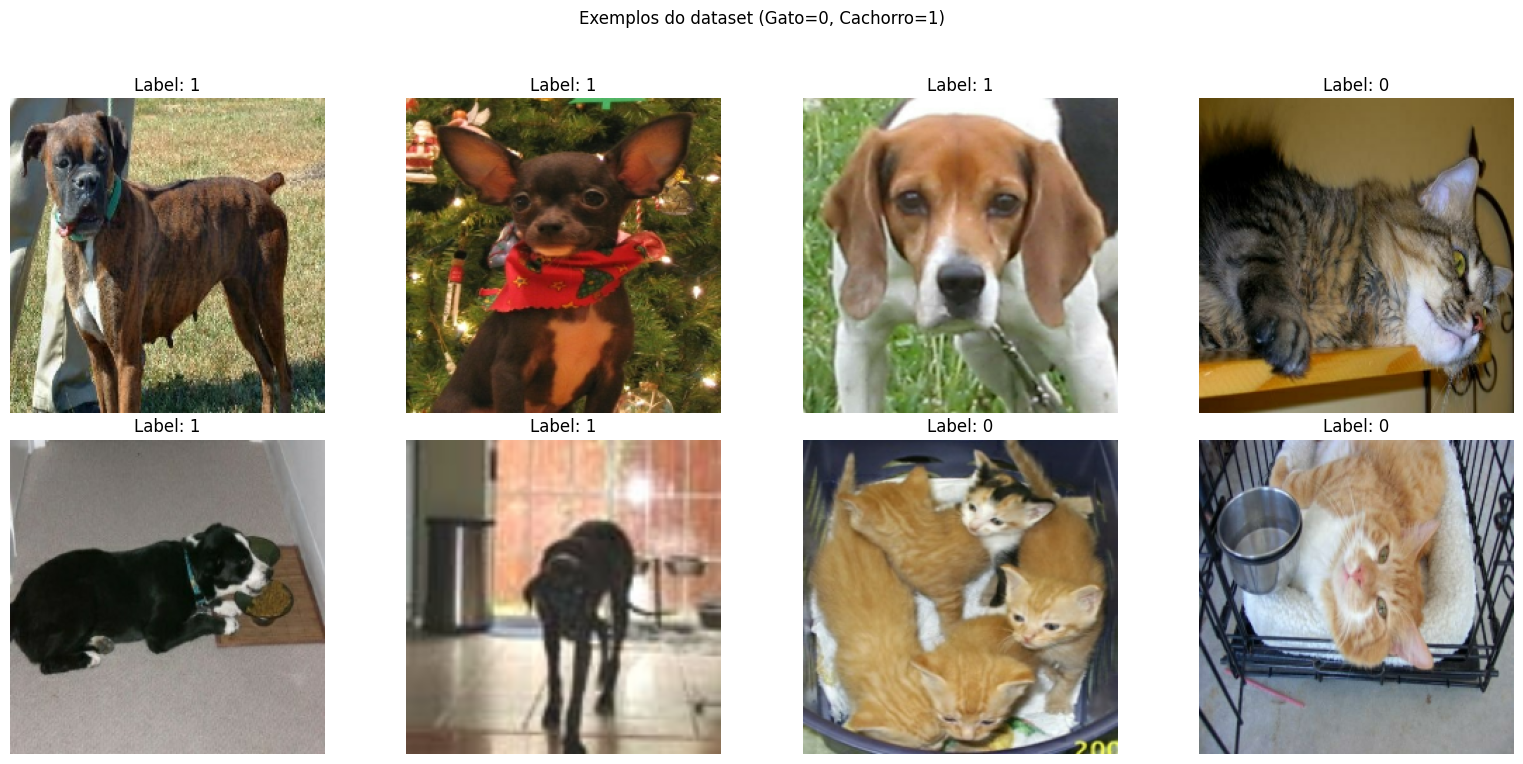

In [4]:
import matplotlib.pyplot as plt

# Pega 8 imagens do dataset de treino
sample_images = []
sample_labels = []

# Take a batch and then iterate through the images in the batch
for images, labels in train_ds.take(1):
    for i in range(min(8, images.shape[0])): # Take up to 8 images from the batch
        sample_images.append(images[i].numpy())
        sample_labels.append(labels[i].numpy())

# Mostra as imagens individualmente em um grid
plt.figure(figsize=(16, 8))
for i in range(len(sample_images)):
    plt.subplot(2, 4, i + 1) # Create a 2x4 grid
    plt.imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i]}")
    plt.axis('off')

plt.suptitle("Exemplos do dataset (Gato=0, Cachorro=1)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

Importar o VGG16 pré-treinado (sem a camada final)

In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

Carregar o modelo base VGG16 pré-treinado no ImageNet, sem a camada final (top=False)

In [6]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congela as camadas do VGG16 para feature extraction

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Construir modelo completo adicionando camadas densas para classificação binária

In [7]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Saída binária: gato ou cachorro
])


Resumo do modelo

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Compilar o modelo

In [9]:
# Compile o modelo com binary_crossentropy para classificação binária
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',   # ou Adam(lr=1e-4) para taxa de aprendizado menor
    metrics=['accuracy']
)

# Treina o modelo usando os datasets do TFDS diretamente
history = model.fit(
    train_ds.prefetch(tf.data.AUTOTUNE),    # treino em batch
    epochs=10,
    validation_data=val_ds.prefetch(tf.data.AUTOTUNE)
)

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 136s 211ms/step - accuracy: 0.8199 - loss: 0.5464 - val_accuracy: 0.9132 - val_loss: 0.1985
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - accuracy: 0.9193 - loss: 0.1993 - val_accuracy: 0.9084 - val_loss: 0.2038
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 106s 183ms/step - accuracy: 0.9256 - loss: 0.1790 - val_accuracy: 0.9325 - val_loss: 0.1621
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 107s 183ms/step - accuracy: 0.9341 - loss: 0.1633 - val_accuracy: 0.9321 - val_loss: 0.1716
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 143s 185ms/step - accuracy: 0.9305 - loss: 0.1660 - val_accuracy: 0.9295 - val_loss: 0.1863
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 115s 198ms/step - accuracy: 0.9400 - loss: 0.1429 - val_accuracy: 0.9291 - val_loss: 0.1807
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 108s 185ms/step - accuracy: 0.9460 - loss: 0.1295 - val_accuracy: 0.9239 - val_loss: 0.1773
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 142s 185ms/step - accuracy: 0.9522 -

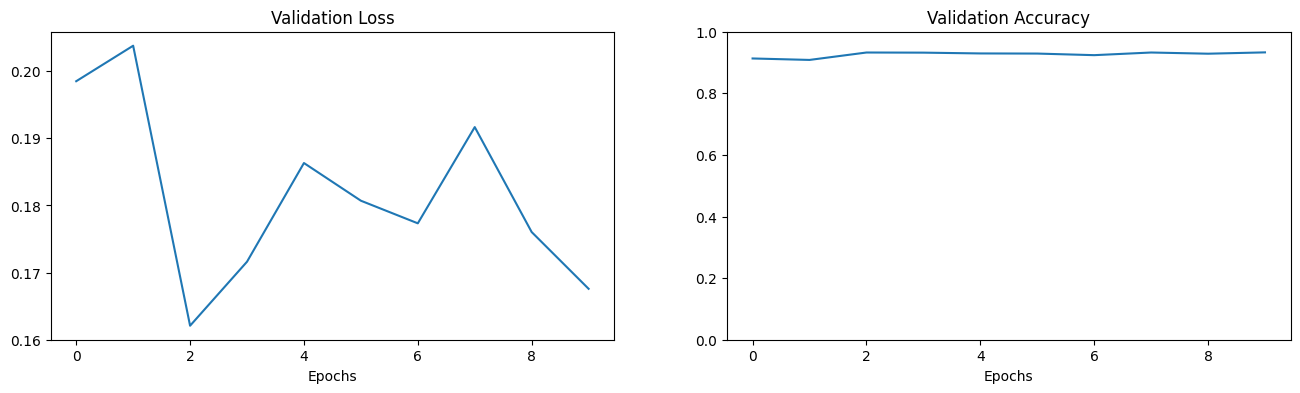

In [10]:
fig = plt.figure(figsize=(16,4))

# Gráfico da perda na validação
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")

# Gráfico da acurácia na validação
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])  # <-- nome atualizado
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0, 1)

plt.show()


In [14]:
loss, accuracy = model.evaluate(test_ds, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.15126875042915344
Test accuracy: 0.9333620071411133


Testar outra imagem

In [25]:
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing import image

# Função para carregar e pré-processar imagem
def load_and_prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # redimensiona
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normaliza
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension
    return img_array

# Função para prever classe
def predict_image_class(model, img_path):
    img = load_and_prepare_image(img_path)
    prediction = model.predict(img)[0][0]
    if prediction < 0.5:
        return "Gato", prediction
    else:
        return "Cachorro", prediction

# Upload da imagem
uploaded = files.upload()

# Pega o nome do arquivo enviado
img_path = list(uploaded.keys())[0]

# Previsão
classe, prob = predict_image_class(model_new, img_path)
print(f"Classe prevista: {classe} (confiança: {prob:.2f})")


Saving gato4.jpeg to gato4.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Classe prevista: Cachorro (confiança: 0.89)
